# Спортивный анализ данных. Платформа Kaggle. Домашнее задание №6

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

## Задание 0 
Выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

### Загрузим датасет

In [1]:
from typing import List, Optional
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
!pip install catboost
!pip install shap
import shap
import catboost as cb
from sklearn.inspection import permutation_importance

     |████████████████████████████████| 67.3MB 43kB/s 
     |████████████████████████████████| 358kB 8.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=3e5b5a09833ffdca3c7d5f5a7987eadb2fc1ec7ee5330bd7a3c038cbcd1844cf
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка датасета и вывод размерностей

In [3]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

print("data.shape = {} rows, {} cols".format(*data.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))

data.shape = 180000 rows, 394 cols
lb.shape = 100001 rows, 394 cols


In [4]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

### Преобразуем признак TransactionDT в datetime, прибавив к базовой дате (2017-12-01) исходное значение признака. Из полученного признака выделим год, месяц, день недели, час, день.

In [5]:
data['TransactionDT'] = pd.to_timedelta(data['TransactionDT'], unit='s')
base_date = pd.to_datetime('2017-12-01')
data['TransactionDT'] = data['TransactionDT'] + base_date

data["year"] = data["TransactionDT"].dt.year
data["month_of_year"] = data["TransactionDT"].dt.month
data["day_of_week"] = data["TransactionDT"].dt.weekday
data["week_of_year"] = data["TransactionDT"].dt.weekofyear
data["hour"] = data["TransactionDT"].dt.hour
data["day"] = data["TransactionDT"].dt.day
data.drop(columns=['TransactionDT', 'TransactionID'], inplace=True)

lb['TransactionDT'] = pd.to_timedelta(lb['TransactionDT'], unit='s')
base_date = pd.to_datetime('2017-12-01')
lb['TransactionDT'] = lb['TransactionDT'] + base_date
lb["year"] = lb["TransactionDT"].dt.year
lb["month_of_year"] = lb["TransactionDT"].dt.month
lb["day_of_week"] = lb["TransactionDT"].dt.weekday
lb["week_of_year"] = lb["TransactionDT"].dt.weekofyear
lb["hour"] = lb["TransactionDT"].dt.hour
lb["day"] = lb["TransactionDT"].dt.day
lb.drop(columns=['TransactionDT', 'TransactionID'], inplace=True)

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


### Выполним конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2

In [6]:
def create_concat_feature(data: pd.DataFrame, features: List[str]) -> pd.Series:
    """
    Возвращает признак (колонку), представляющую собой
    конкатенацию признаков features из датафрейма data

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Исходный датафрейм.

    features: List[str]
        Список с названием признаков, из которых будет создаваться новый.

    Returns
    -------
    new_feature: pd.Series
        Новый признак.

    """

    result = pd.Series(data='', index=data.index)
    for feature in features:
      result += data[feature].astype(str) + '|'
    return result

In [7]:
data['card1+card2'] = create_concat_feature(data, ['card1', 'card2'])
data['card1+card2+card3+card5'] = create_concat_feature(data, ['card1', 'card2', 'card3', 'card5'])
data['card1+card2+card3+card5+addr1+addr2'] = create_concat_feature(data, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

lb['card1+card2'] = create_concat_feature(lb, ['card1', 'card2'])
lb['card1+card2+card3+card5'] = create_concat_feature(lb, ['card1', 'card2', 'card3', 'card5'])
lb['card1+card2+card3+card5+addr1+addr2'] = create_concat_feature(lb, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

### Сделаем FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [8]:
def frequency_encoder(data: pd.DataFrame,
                            features: List[str],
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Уникальные значения в признаках features датафрейма
    data заменяются частотой их появления в этом датафрейме

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для преобразования признаков.

    features: List[str]
        Список с названием признаков, для которых произвести
        частотное кодирование.

    delete_old - флаг - удалять ли исходные признаки

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными (удаленными признаками).

    """
    for feature in features:
      stat = data[feature].value_counts().reset_index().rename(columns={'index': feature, feature: feature+'_cnt'})
      stat[feature+'_freq'] = stat[feature+'_cnt']/stat[feature+'_cnt'].sum()
      stat.drop(columns=[feature+'_cnt'], inplace=True)
      data = pd.merge(data, stat, how='left', on=feature)
      del stat
      if delete_old == True:
        data.drop(columns=[feature], inplace=True)
    return data

In [9]:
columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']
data = frequency_encoder(data, columns, delete_old=False)
lb = frequency_encoder(lb, columns, delete_old=False)

### Создадим признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [10]:
def add_stat_features(data: pd.DataFrame,
                            groupby_features: List[str],
                            feature_to_stat: str
                            ) -> pd.DataFrame:
    """
    Вычисляет новые признаки (feature_to_stat/(среднее значение/стандартное отклоненеие для feature_to_stat))  
    с группированием по признакам groupby_features датафрейма data.


    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для создания признаков.

    groupby_features: List[str]
        Список с названием признаков, по которым производится группировка.

    feature_to_stat - признак, на основе которого будут вычисляться статистики

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными признаками.

    """
    for feature in groupby_features:
      stat = data.groupby(feature).agg({feature_to_stat: [np.mean, np.std]}).reset_index()
      stat.columns = [feature, 'mean_' + feature_to_stat, 'std_' + feature_to_stat]
      stat[feature_to_stat+'_'+feature+'_stat'] = stat['mean_' + feature_to_stat]/stat['std_' + feature_to_stat]
      stat.drop(columns=['mean_' + feature_to_stat, 'std_' + feature_to_stat], inplace=True)
      data = pd.merge(data, stat, on=feature, how='left')
      data[feature_to_stat+'_'+feature+'_stat'] = data[feature_to_stat] / data[feature_to_stat+'_'+feature+'_stat']
      del stat
    return data

In [11]:
groupby_features = ['card1','card2','card3','card4','card5','card6','addr1','addr2',
                    'card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2']

data = add_stat_features(data, groupby_features=groupby_features, feature_to_stat='TransactionAmt')
lb = add_stat_features(lb, groupby_features=groupby_features, feature_to_stat='TransactionAmt')

### Создадим признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [12]:
groupby_features = ['card1','card2','card3','card4','card5','card6','addr1','addr2',
                    'card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2']

data = add_stat_features(data, groupby_features=groupby_features, feature_to_stat='D15')
lb = add_stat_features(lb, groupby_features=groupby_features, feature_to_stat='D15')

### Выделим дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создадим отдельный признак - логарифм от TransactionAmt

In [13]:
def log_transform(data: pd.DataFrame,
                            feature_to_transform: str,
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Создает 3 новых признака в датафрейме data на основе 
    признака feature_to_transform: целая часть признака,
    дробная часть признака и логарифм от признака


    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для создания признаков.

    feature_to_transform - признак, на основе которого будут вычисляться другие признаки

    delete_old - удалять ли исходный признак

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными признаками.

    """
    data[feature_to_transform + '_left'] = data[feature_to_transform].apply(np.floor)
    data[feature_to_transform + '_right'] = data[feature_to_transform] - data[feature_to_transform + '_left']
    data['log_' + feature_to_transform] = data[feature_to_transform].apply(np.log)
    if delete_old == True:
      data.drop(columns=[feature_to_transform], inplace=True)

    return data

In [14]:
data = log_transform(data, 'TransactionAmt', delete_old=False)
lb = log_transform(lb, 'TransactionAmt', delete_old=False)

### Выполним предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain и сделаем Frequency Encoding для очищенных признаков.

In [15]:
email_columns = ['P_emaildomain', 'R_emaildomain']

In [16]:
for column in email_columns:
  data[column] = data[column].astype(str)
  lb[column] = lb[column].astype(str)

In [17]:
data['P_emaildomain'] = data['P_emaildomain'].apply(lambda x: x.split('.')[-1])
data['R_emaildomain'] = data['R_emaildomain'].apply(lambda x: x.split('.')[-1])

lb['P_emaildomain'] = lb['P_emaildomain'].apply(lambda x: x.split('.')[-1])
lb['R_emaildomain'] = lb['R_emaildomain'].apply(lambda x: x.split('.')[-1])

In [18]:
data = frequency_encoder(data, email_columns, delete_old=False)
lb = frequency_encoder(lb, email_columns, delete_old=False)

In [19]:
data.drop(columns=['card1+card2',	'card1+card2+card3+card5',	'card1+card2+card3+card5+addr1+addr2'], inplace=True)
lb.drop(columns=['card1+card2',	'card1+card2+card3+card5',	'card1+card2+card3+card5+addr1+addr2'], inplace=True)

### Зафиксируем базовое качество модели

In [20]:
categorical_features = data.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()
del categorical_features
categorical_feature_names

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [21]:
for feature in categorical_feature_names:
    data[feature] = data[feature].astype(str)
    lb[feature] = lb[feature].astype(str)

y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=False, random_state=1,
)

In [22]:
cb_params = {
    "n_estimators": 5000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    #"task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [23]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734327	test: 0.6576363	best: 0.6576363 (0)	total: 12.4ms	remaining: 1m 1s
100:	learn: 0.8759093	test: 0.8554488	best: 0.8554500 (97)	total: 1.08s	remaining: 52.3s
200:	learn: 0.8875515	test: 0.8618475	best: 0.8618475 (200)	total: 2.12s	remaining: 50.5s
300:	learn: 0.8955858	test: 0.8665485	best: 0.8665485 (300)	total: 3.2s	remaining: 49.9s
400:	learn: 0.8989037	test: 0.8695065	best: 0.8695506 (399)	total: 4.25s	remaining: 48.8s
500:	learn: 0.9029104	test: 0.8711179	best: 0.8711179 (500)	total: 5.31s	remaining: 47.7s
600:	learn: 0.9067005	test: 0.8745780	best: 0.8745780 (600)	total: 6.39s	remaining: 46.7s
700:	learn: 0.9097006	test: 0.8774444	best: 0.8774609 (699)	total: 7.48s	remaining: 45.9s
800:	learn: 0.9117339	test: 0.8795357	best: 0.8795929 (778)	total: 8.54s	remaining: 44.7s
900:	learn: 0.9150419	test: 0.8831103	best: 0.8831736 (898)	total: 9.6s	remaining: 43.7s
1000:	learn: 0.9172548	test: 0.8848803	best: 0.8850260 (990)	total: 10.7s	remaining: 42.7s
1100:	learn: 0.

In [24]:
train_pred = model_catb.predict_proba(x_train)
valid_pred = model_catb.predict_proba(x_valid)
lb_pred = model_catb.predict_proba(x_lb)

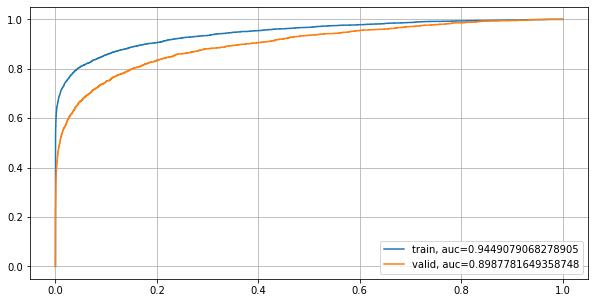

In [25]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [26]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.939631222942139, 0.9499242178207637)
Valid confidence interval = (0.8903329657283648, 0.9070871392822749)
Liderboard score = 0.8662588517339664


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


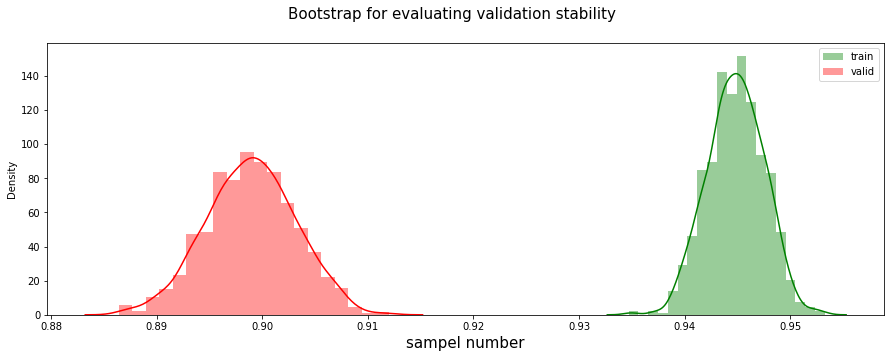

In [27]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.distplot(train_scores,  color="green", bins=20, label='train')
sns.distplot(valid_scores,  color="red", bins=20, label='valid')
plt.xlabel("sampel number", size=15)
plt.legend()

## Задание 1
Использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [28]:
def plot_feature_importance(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10, 80))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

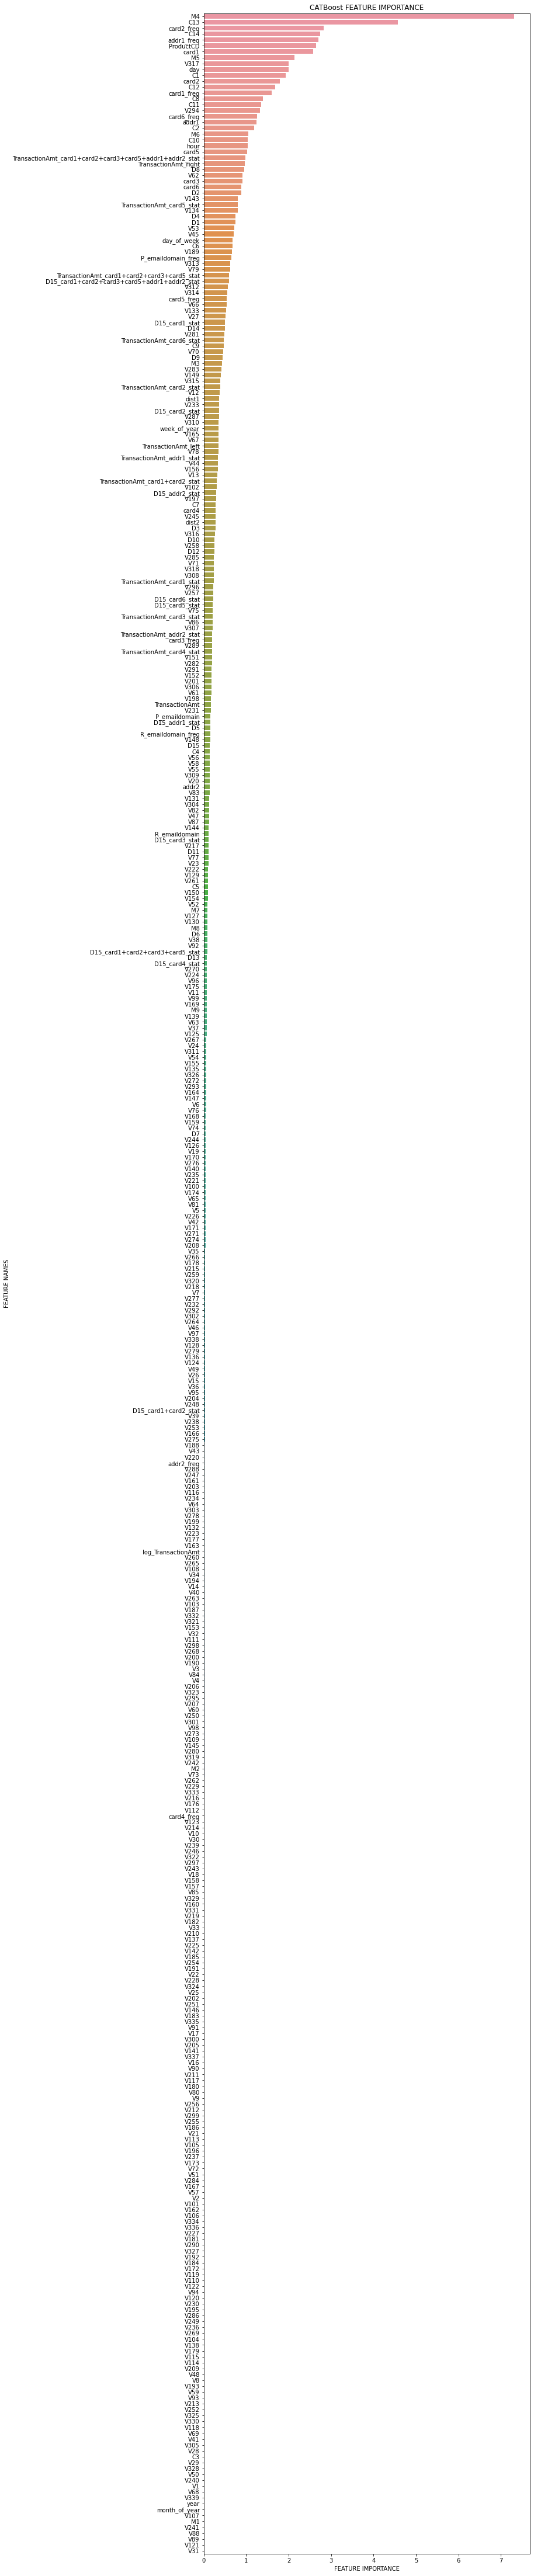

In [29]:
top_features = plot_feature_importance(model_catb.get_feature_importance(), x_train.columns, 'CATBoost')

In [30]:
top_200 = top_features[:200]

## Задание 2
Удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [31]:
categorical_features = x_train[top_200].select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()
del categorical_features
categorical_feature_names

['M4',
 'ProductCD',
 'M5',
 'M6',
 'card6',
 'M3',
 'card4',
 'P_emaildomain',
 'R_emaildomain',
 'M7',
 'M8',
 'M9']

In [32]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train[top_200], y_train, eval_set=[(x_valid[top_200], y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6065117	test: 0.6371406	best: 0.6371406 (0)	total: 11.6ms	remaining: 58s
100:	learn: 0.8781057	test: 0.8591454	best: 0.8592104 (97)	total: 1.06s	remaining: 51.4s
200:	learn: 0.8895057	test: 0.8663350	best: 0.8663350 (200)	total: 2.08s	remaining: 49.8s
300:	learn: 0.8979101	test: 0.8707869	best: 0.8707985 (299)	total: 3.12s	remaining: 48.7s
400:	learn: 0.9024979	test: 0.8746293	best: 0.8746293 (400)	total: 4.17s	remaining: 47.8s
500:	learn: 0.9071058	test: 0.8782404	best: 0.8782471 (496)	total: 5.16s	remaining: 46.3s
600:	learn: 0.9117751	test: 0.8808167	best: 0.8808167 (600)	total: 6.17s	remaining: 45.1s
700:	learn: 0.9155124	test: 0.8838817	best: 0.8838817 (700)	total: 7.16s	remaining: 43.9s
800:	learn: 0.9180880	test: 0.8861857	best: 0.8862231 (776)	total: 8.18s	remaining: 42.9s
900:	learn: 0.9211075	test: 0.8888344	best: 0.8888344 (900)	total: 9.21s	remaining: 41.9s
1000:	learn: 0.9235244	test: 0.8901164	best: 0.8901604 (997)	total: 10.2s	remaining: 40.8s
1100:	learn: 0.

In [33]:
train_pred = model_catb.predict_proba(x_train[top_200])
valid_pred = model_catb.predict_proba(x_valid[top_200])
lb_pred = model_catb.predict_proba(x_lb[top_200])

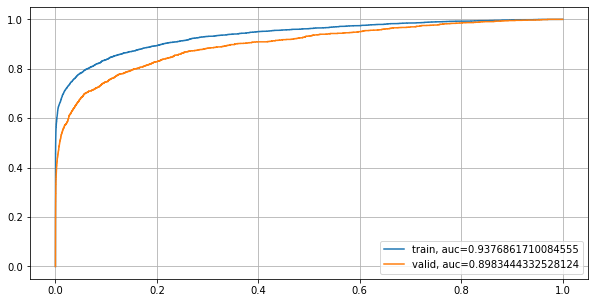

In [34]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [35]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train[top_200])[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid[top_200])[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9324723883405313, 0.9429199225643046)
Valid confidence interval = (0.8896551353164927, 0.9064022567646493)
Liderboard score = 0.8698495913141436


Вывод: точность повысилась

## Задание 3
Использовать permutation importance, выполнить задание 1 и 2.

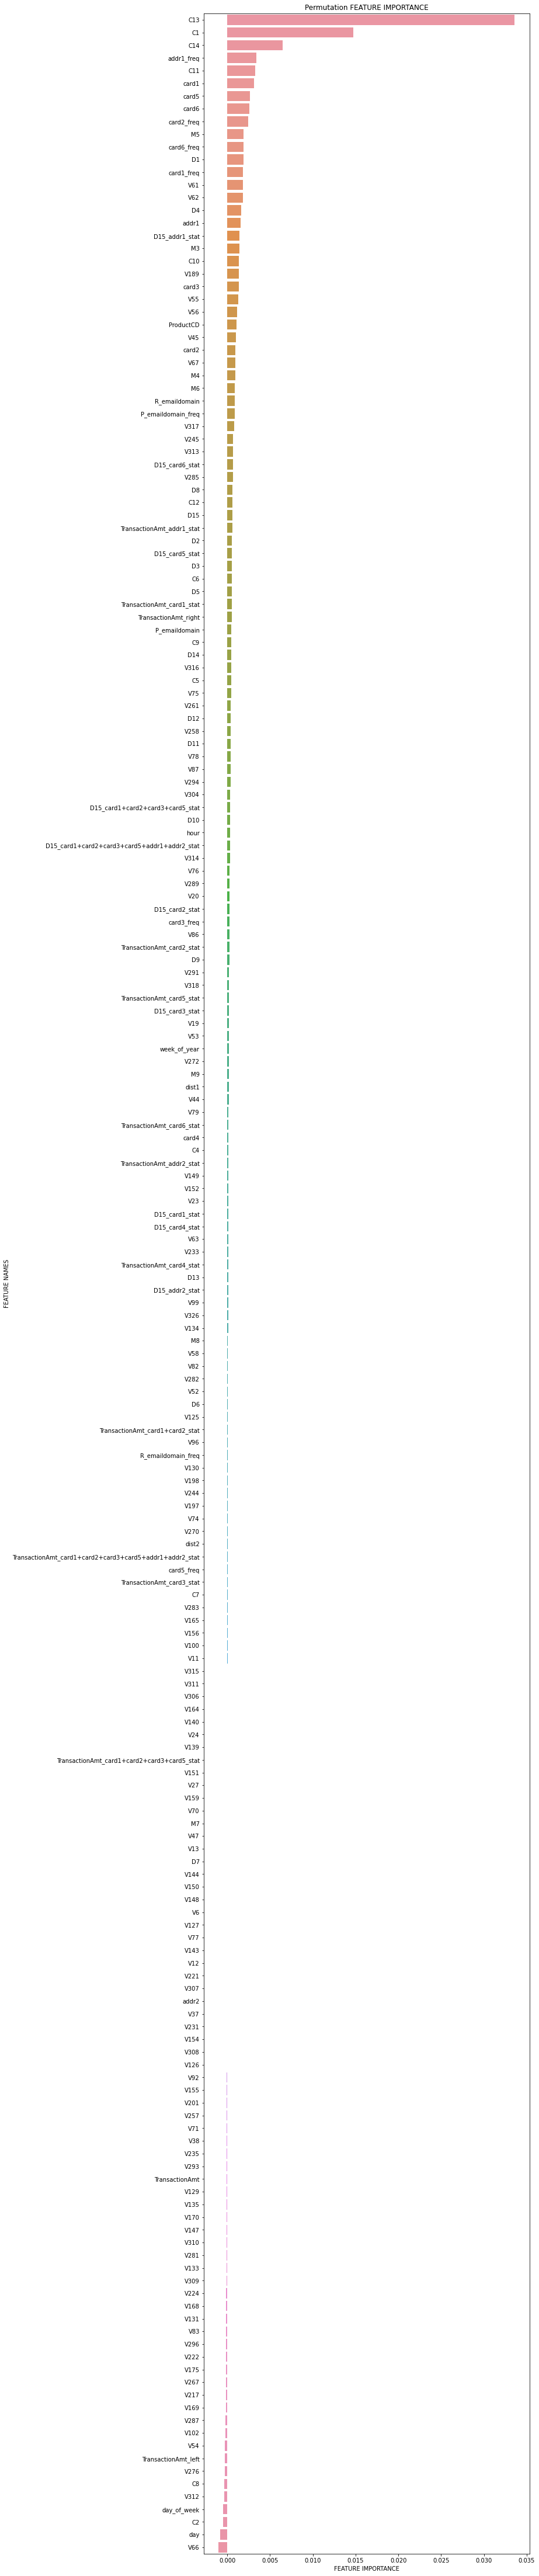

In [36]:
importance = permutation_importance(model_catb, x_valid[top_200], y_valid, scoring='roc_auc', n_jobs=6, random_state=27)
top_features = plot_feature_importance(importance['importances_mean'], x_train[top_200].columns, 'Permutation')

In [37]:
top_190 = top_features[:190]

In [38]:
categorical_features = x_train[top_190].select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()
del categorical_features
categorical_feature_names

['card6',
 'M5',
 'M3',
 'ProductCD',
 'M4',
 'M6',
 'R_emaildomain',
 'P_emaildomain',
 'M9',
 'card4',
 'M8',
 'M7']

In [39]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train[top_190], y_train, eval_set=[(x_valid[top_190], y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6826991	test: 0.6897787	best: 0.6897787 (0)	total: 11.9ms	remaining: 59.6s
100:	learn: 0.8738010	test: 0.8528866	best: 0.8528866 (100)	total: 1.08s	remaining: 52.6s
200:	learn: 0.8878340	test: 0.8639665	best: 0.8639665 (200)	total: 2.1s	remaining: 50.2s
300:	learn: 0.8960147	test: 0.8699569	best: 0.8699569 (300)	total: 3.11s	remaining: 48.6s
400:	learn: 0.9006072	test: 0.8728202	best: 0.8728202 (400)	total: 4.13s	remaining: 47.4s
500:	learn: 0.9046992	test: 0.8755063	best: 0.8755063 (500)	total: 5.15s	remaining: 46.3s
600:	learn: 0.9089175	test: 0.8797218	best: 0.8797626 (599)	total: 6.21s	remaining: 45.5s
700:	learn: 0.9128710	test: 0.8824833	best: 0.8824833 (700)	total: 7.24s	remaining: 44.4s
800:	learn: 0.9154512	test: 0.8852097	best: 0.8852100 (797)	total: 8.26s	remaining: 43.3s
900:	learn: 0.9188932	test: 0.8866442	best: 0.8866442 (900)	total: 9.28s	remaining: 42.2s
1000:	learn: 0.9216991	test: 0.8880707	best: 0.8881027 (990)	total: 10.3s	remaining: 41.1s
1100:	learn: 

In [40]:
train_pred = model_catb.predict_proba(x_train[top_190])
valid_pred = model_catb.predict_proba(x_valid[top_190])
lb_pred = model_catb.predict_proba(x_lb[top_190])

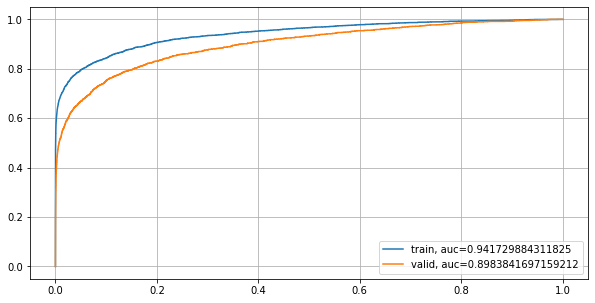

In [41]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [42]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train[top_190])[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid[top_190])[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9364847775856123, 0.9468554388924123)
Valid confidence interval = (0.8898863659091146, 0.9066788058235435)
Liderboard score = 0.8673868794393804


Вывод: точность уменьшилась

## Задание 4
Использовать shap, выполнить задание 1 и 2.

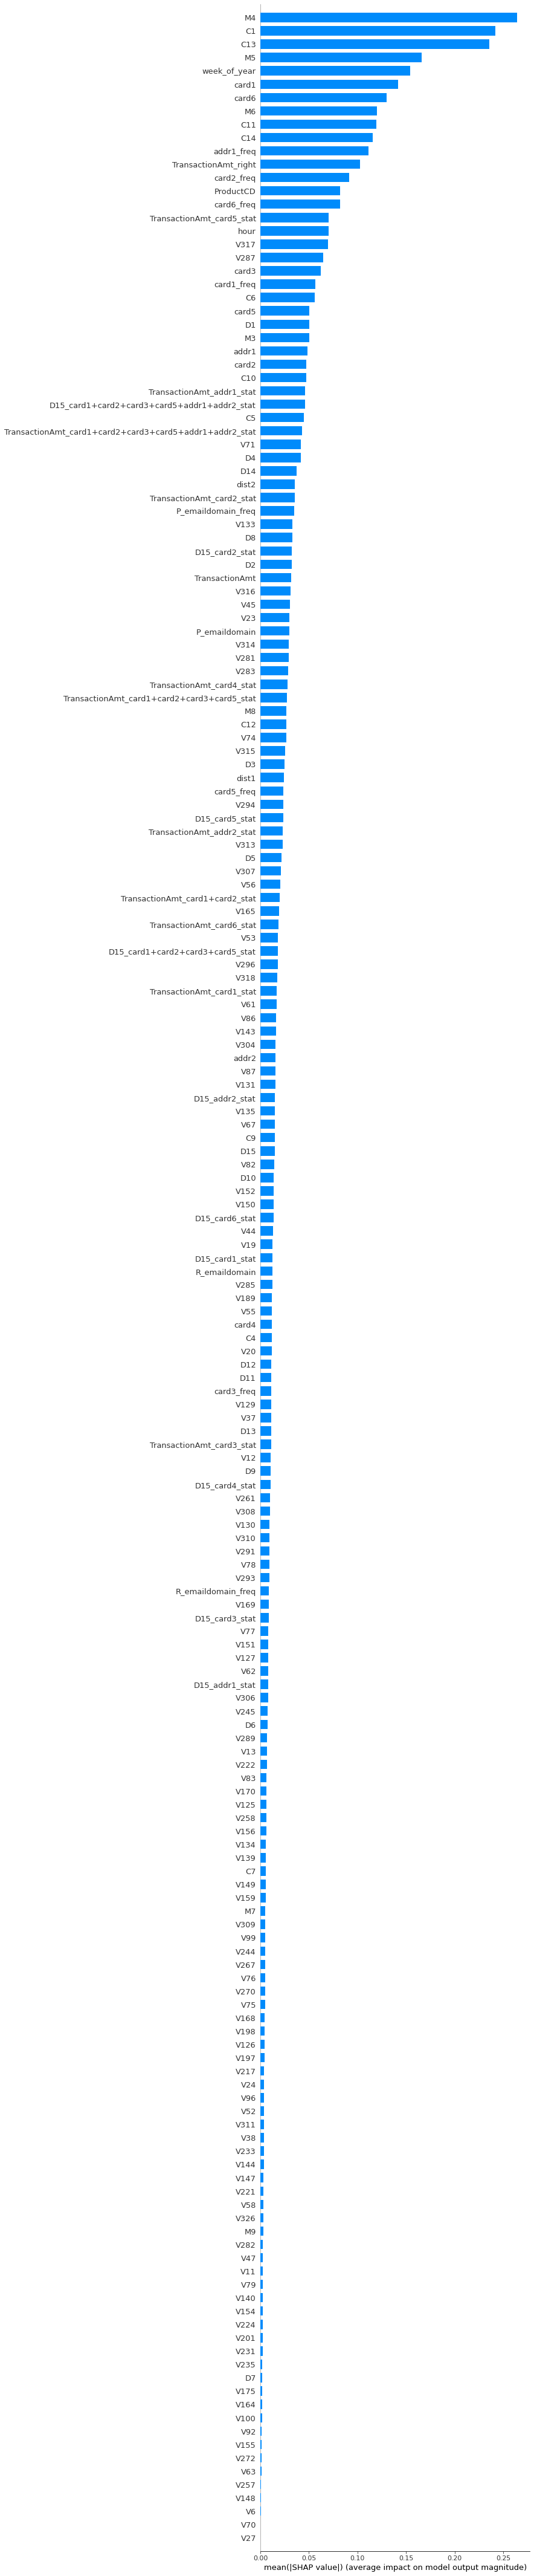

In [43]:
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(cb.Pool(x_valid[top_190], y_valid, cat_features=categorical_feature_names))
shap.summary_plot(shap_values, x_valid[top_190], plot_type="bar", max_display=x_valid[top_190].shape[1])

In [45]:
vals= np.abs(shap_values).mean(0) 
feature_importance = pd.DataFrame(list(zip(x_valid[top_190].columns, vals)), columns=['col_name','feature_importance_vals']) 
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [46]:
feature_importance

,col_name,feature_importance_vals
28,M4,0.264126
1,C1,0.241918
0,C13,0.235772
9,M5,0.165806
81,week_of_year,0.153865
...,...,...
165,V257,0.000955
148,V148,0.000799
149,V6,0.000346
141,V70,0.000068


In [47]:
top_180 = list(feature_importance['col_name'].values)[:180]

In [48]:
top_180

['M4',
 'C1',
 'C13',
 'M5',
 'week_of_year',
 'card1',
 'card6',
 'M6',
 'C11',
 'C14',
 'addr1_freq',
 'TransactionAmt_right',
 'card2_freq',
 'ProductCD',
 'card6_freq',
 'TransactionAmt_card5_stat',
 'hour',
 'V317',
 'V287',
 'card3',
 'card1_freq',
 'C6',
 'card5',
 'D1',
 'M3',
 'addr1',
 'card2',
 'C10',
 'TransactionAmt_addr1_stat',
 'D15_card1+card2+card3+card5+addr1+addr2_stat',
 'C5',
 'TransactionAmt_card1+card2+card3+card5+addr1+addr2_stat',
 'V71',
 'D4',
 'D14',
 'dist2',
 'TransactionAmt_card2_stat',
 'P_emaildomain_freq',
 'V133',
 'D8',
 'D15_card2_stat',
 'D2',
 'TransactionAmt',
 'V316',
 'V45',
 'V23',
 'P_emaildomain',
 'V314',
 'V281',
 'V283',
 'TransactionAmt_card4_stat',
 'TransactionAmt_card1+card2+card3+card5_stat',
 'M8',
 'C12',
 'V74',
 'V315',
 'D3',
 'dist1',
 'card5_freq',
 'V294',
 'D15_card5_stat',
 'TransactionAmt_addr2_stat',
 'V313',
 'D5',
 'V307',
 'V56',
 'TransactionAmt_card1+card2_stat',
 'V165',
 'TransactionAmt_card6_stat',
 'V53',
 'D15_c

In [49]:
categorical_features = x_train[top_180].select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()
del categorical_features
categorical_feature_names

['M4',
 'M5',
 'card6',
 'M6',
 'ProductCD',
 'M3',
 'P_emaildomain',
 'M8',
 'R_emaildomain',
 'card4',
 'M7',
 'M9']

In [50]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train[top_180], y_train, eval_set=[(x_valid[top_180], y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6154176	test: 0.6616126	best: 0.6616126 (0)	total: 11.5ms	remaining: 57.7s
100:	learn: 0.8772980	test: 0.8536102	best: 0.8536953 (95)	total: 1.08s	remaining: 52.4s
200:	learn: 0.8906659	test: 0.8658237	best: 0.8658237 (200)	total: 2.12s	remaining: 50.6s
300:	learn: 0.8976943	test: 0.8724619	best: 0.8724619 (300)	total: 3.17s	remaining: 49.5s
400:	learn: 0.9026827	test: 0.8762536	best: 0.8762536 (400)	total: 4.19s	remaining: 48.1s
500:	learn: 0.9067899	test: 0.8795601	best: 0.8795601 (500)	total: 5.25s	remaining: 47.1s
600:	learn: 0.9107227	test: 0.8820338	best: 0.8820338 (600)	total: 6.28s	remaining: 46s
700:	learn: 0.9143211	test: 0.8843450	best: 0.8843921 (699)	total: 7.36s	remaining: 45.1s
800:	learn: 0.9167536	test: 0.8862578	best: 0.8862578 (800)	total: 8.39s	remaining: 44s
900:	learn: 0.9201350	test: 0.8884696	best: 0.8884696 (900)	total: 9.4s	remaining: 42.8s
1000:	learn: 0.9230203	test: 0.8896427	best: 0.8896427 (1000)	total: 10.4s	remaining: 41.6s
1100:	learn: 0.92

In [51]:
train_pred = model_catb.predict_proba(x_train[top_180])
valid_pred = model_catb.predict_proba(x_valid[top_180])
lb_pred = model_catb.predict_proba(x_lb[top_180])

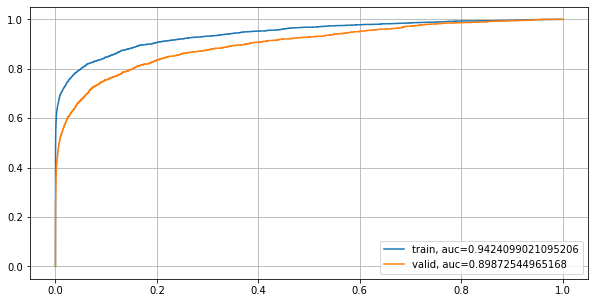

In [52]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [53]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train[top_180])[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid[top_180])[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9372992666023697, 0.9474656074066367)
Valid confidence interval = (0.8900333542942152, 0.9068172061061964)
Liderboard score = 0.8682215805353077


Вывод: точность увеличилась

## Задание 5
Построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

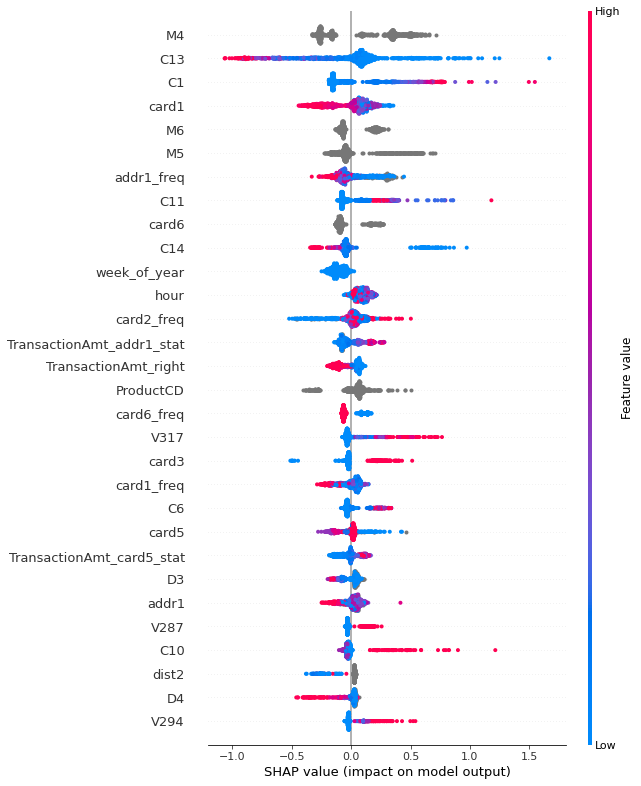

In [54]:
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(cb.Pool(x_valid[top_180].iloc[1000:2000], y_valid.iloc[1000:2000], cat_features=categorical_feature_names))
shap.summary_plot(shap_values, x_valid[top_180].iloc[1000:2000], max_display=30)

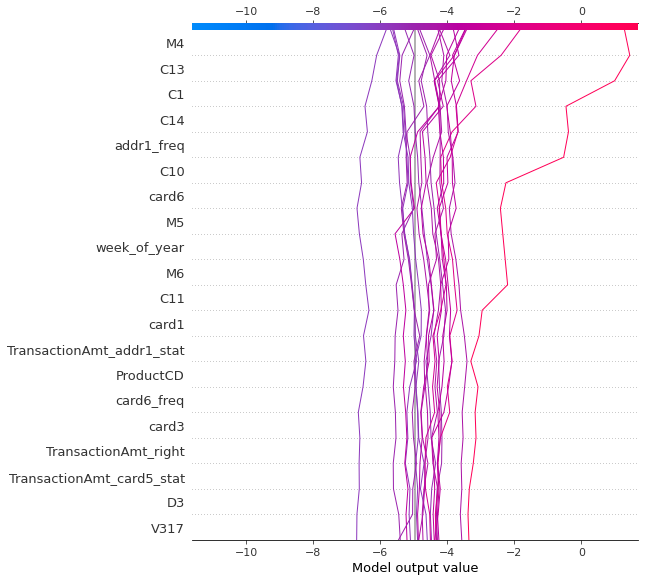

In [58]:
expected_value = explainer.expected_value
select = range(20)
samples = x_valid[top_180].iloc[select]
features_display = x_valid[top_180].loc[samples.index]
shap_values = explainer.shap_values(samples)
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], )

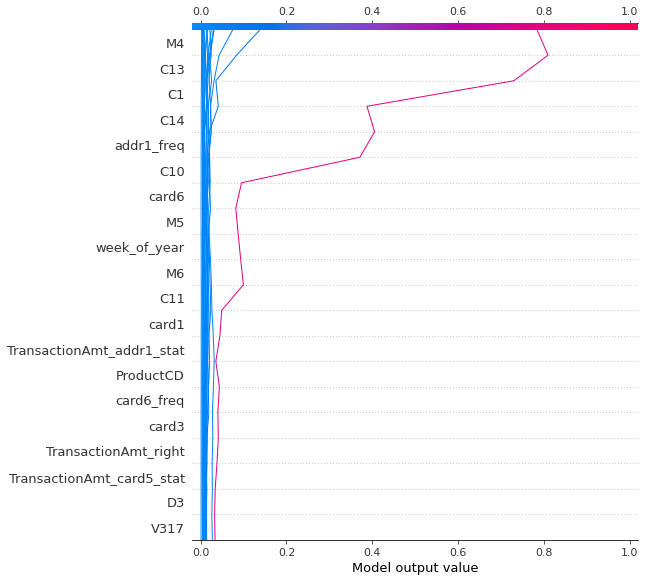

In [59]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

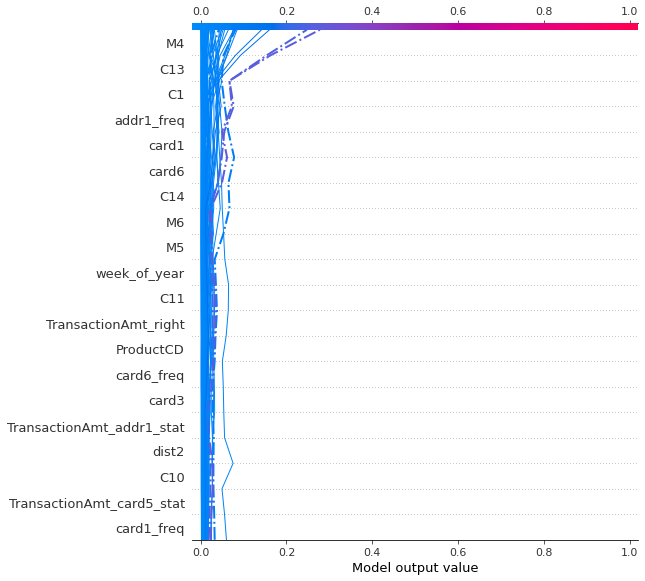

In [65]:
shap_values = explainer.shap_values(x_valid[top_180], y_valid)
y_pred = (shap_values.sum(1) + expected_value) > 0

misclassified = y_pred != y_valid
shap.decision_plot(
    expected_value, shap_values[100:200], features_display.iloc[100:200], link='logit', highlight=misclassified[100:200]
)

Вывод: есть ложноположительные ответы, на принятие которых сильное влияние оказали признаки: C13, M4